## Calibration of the HYPSO-2 captures in 2025 11 of may 2025

In [1]:
from hypso import Hypso1, Hypso2
import os 
import sys
import matplotlib.pyplot as plt
from global_land_mask import globe 
import numpy as np 

parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

import funcions_autonom as f
import atmosperic_correction as atm_c ## obs denne het før ac -> kan føre til feil dersom man ikke finner funkjsons navn
import base as ac

import xarray as xr
import re
import math
import importlib

from sklearn.cluster import KMeans
from collections import defaultdict

from sklearn.preprocessing import StandardScaler

np.random.seed(42)

dir_path = ".." ## filene hentes fra en mappe over der vi er nå

### Uploading data

In [2]:
path_cla_atm_250511 = os.path.join(dir_path, "image64N9E_2025-05-11T12-00-37Z-l1c.nc.polymer.nc")######
cla_atm_250511 = xr.open_dataset(path_cla_atm_250511)

latitude_250511 = np.array(cla_atm_250511['latitude'])
longitude_250511 = np.array(cla_atm_250511['longitude'])

#### HYPSO 2 Capture, 11.may 2025

In [3]:
## H2
i_250511_2 = os.path.join(dir_path, "image64N9E_2025-05-11T12-00-37Z-l1a.nc")
i_250511_2_b = os.path.join(dir_path, "image64N9E_2025-05-11T12-00-37Z-l1b.nc")
i_250511_2_c = os.path.join(dir_path, "image64N9E_2025-05-11T12-00-37Z-l1c.nc")
i_250511_2_d = os.path.join(dir_path, "image64N9E_2025-05-11T12-00-37Z-l1d.nc")

satobj_h1_250511_2 = Hypso2( path = i_250511_2, verbose = True )

l1a_cube_250511_2 = satobj_h1_250511_2.l1a_cube
l1b_cube_250511_2 = Hypso2( path = i_250511_2_b, verbose = True )
l1c_cube_250511_2 = Hypso2( path = i_250511_2_c, verbose = True )
l1d_cube_250511_2 = Hypso2( path = i_250511_2_d, verbose = True )

l1c_cube_250511_2 = l1c_cube_250511_2.l1c_cube
l1b_cube_250511_2 = l1b_cube_250511_2.l1b_cube
l1d_cube_250511_2 = l1d_cube_250511_2.l1d_cube

satobj_h1_250511_2.run_direct_georeferencing() # in order to get the longiyudes and latitudes 

[INFO] Loading L1a capture image64N9E_2025-05-11T12-00-37Z
[INFO] Capture spatial dimensions: (598, 1092)
[INFO] Capture capture type: wide
[INFO] Loading L1b capture image64N9E_2025-05-11T12-00-37Z
[INFO] Capture spatial dimensions: (598, 1092)
[INFO] Capture capture type: wide
[INFO] Loading L1c capture image64N9E_2025-05-11T12-00-37Z
[INFO] Capture spatial dimensions: (598, 1092)
[INFO] Capture capture type: wide
[INFO] Loading L1d capture image64N9E_2025-05-11T12-00-37Z
[INFO] Capture spatial dimensions: (598, 1092)
[INFO] Capture capture type: wide
[INFO] Running direct georeferencing...
[INFO] ADCS samples: 540
[INFO] ADCS time range: 1746964170.000000 to 1746965100.000000
[INFO] Frame time range: 1746964837.479518 to 1746964912.104518
[INFO] 299 sample(s) inside frame time range
[INFO] Interpolating 598 frames
[INFO] Computing pixel latitude and longitude coordinates ...
[INFO] Interpolating pixel coordinate gaps...
[INFO] Direct georeferencing done
[INFO] Running track geometry

In [12]:
calibration_lat = [63.642540, 63.642540, 63.642540, 63.642540] ##
calibration_long = [9.503311, 9.503311, 9.503311, 9.503311]

satobj_h1_250511_2.latitudes

array([[65.42081269, 65.42187044, 65.42292773, ..., 66.35072263,
        66.35141306, 66.35210326],
       [65.41468907, 65.4157465 , 65.41680346, ..., 66.34430982,
        66.34500003, 66.34569001],
       [65.40856879, 65.40962588, 65.41068252, ..., 66.33789671,
        66.3385867 , 66.33927646],
       ...,
       [61.54210351, 61.54301855, 61.54393318, ..., 62.34386487,
        62.34445815, 62.34505124],
       [61.53518965, 61.53610453, 61.53701899, ..., 62.33680498,
        62.33739815, 62.33799112],
       [61.52822963, 61.52914434, 61.53005864, ..., 62.32969363,
        62.33028669, 62.33087955]], shape=(598, 1092))

### H2 m atm korreksjon

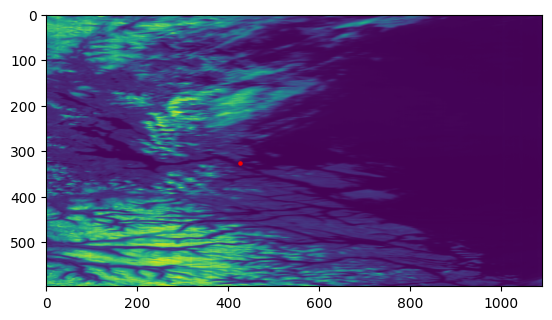

In [14]:
cal_lat, cal_long = f.latLong_to_piksel(calibration_lat, calibration_long, latitude_250511, longitude_250511)


plt.imshow(l1d_cube_250511_2[:,:, 100], origin='upper')
plt.scatter(cal_long[0], cal_lat[0], color='red', s=5)


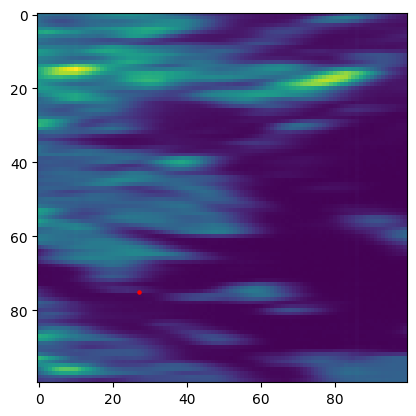

In [16]:
i_start, i_end = 250, 350
j_start, j_end = 400, 500

calibration_x = 0
calibration_y = 0
cropped = l1d_cube_250511_2[i_start:i_end, j_start:j_end, 100]
piksel_row_A3, piksel_col_A3 = f.latLong_to_piksel(calibration_lat, calibration_long, latitude_250511, longitude_250511) #from file funcions_autonom.py

plt.imshow(cropped, origin='upper')
plt.scatter(piksel_col_A3[0] - j_start + calibration_x, piksel_row_A3[0] - i_start + calibration_y, color='red', s=5)


plt.show()

### Calibration hypso 2, on the 11. of May 2025

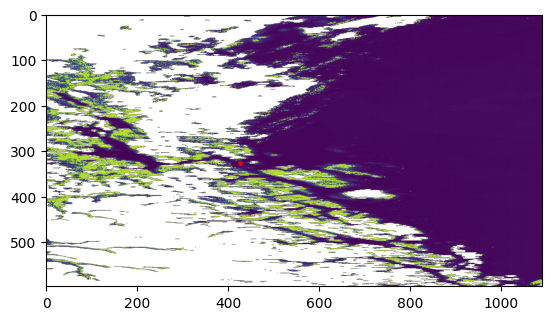

In [11]:
piksel_row_A3, piksel_col_A3 = f.latLong_to_piksel(calibration_lat, calibration_long,latitude_250511, longitude_250511) #from file funcions_autonom.py

plt.imshow(cla_atm_250511['rho_w_460'])
plt.scatter(piksel_col_A3[0], piksel_row_A3[0], color='red', s=5)

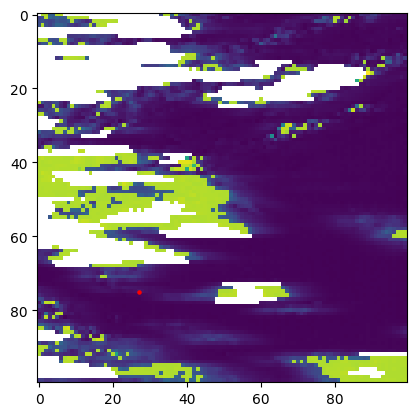

In [18]:
i_start, i_end = 250, 350
j_start, j_end = 400, 500

calibration_x = 0
calibration_y = 0
cropped = cla_atm_250511['rho_w_460'][i_start:i_end, j_start:j_end]
piksel_row_A3, piksel_col_A3 = f.latLong_to_piksel(calibration_lat, calibration_long, latitude_250511, longitude_250511) #from file funcions_autonom.py

plt.imshow(cropped, origin='upper')
plt.scatter(piksel_col_A3[0] - j_start + calibration_x, piksel_row_A3[0] - i_start + calibration_y, color='red', s=5)


plt.show()

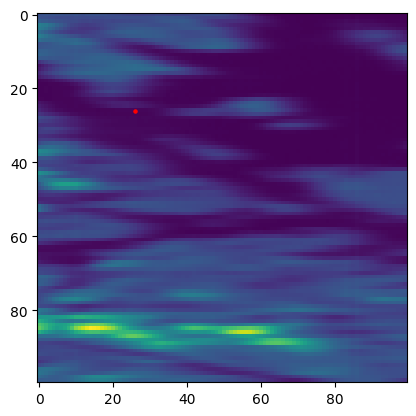

In [ ]:
i_start, i_end = 300, 400
j_start, j_end = 400, 500

calibration_x = 127
calibration_y = 7
cropped = l1d_cube_250511_2[i_start:i_end, j_start:j_end, 100]
piksel_row_A3, piksel_col_A3 = f.latLong_to_piksel(calibration_lat, calibration_long, satobj_h1_250511_2.latitudes, satobj_h1_250511_2.longitudes) #from file funcions_autonom.py

plt.imshow(cropped, origin='upper')
plt.scatter(piksel_col_A3[0] - j_start + calibration_x, piksel_row_A3[0] - i_start + calibration_y, color='red', s=5)


plt.show()

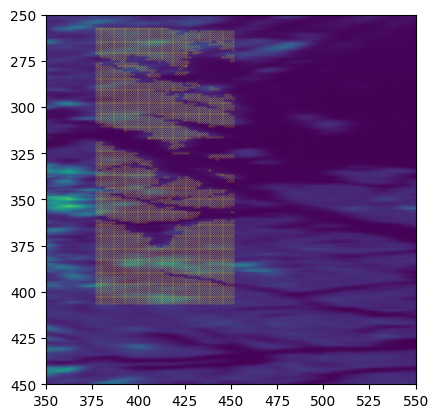

In [ ]:
plt.imshow(l1d_cube_250511_2[:, :, 100], origin='upper')  # Make sure image and scatter match

for i in range(i_start -50 , i_end):
    for j in range(j_start -150 , j_end - 175):
        if globe.is_land(satobj_h1_250511_2.latitudes[i][j], satobj_h1_250511_2.longitudes[i][j]):
            plt.scatter(j + calibration_x, i + calibration_y, color='yellow', s=0.01)

# Crop to region x = 300–500 and y = 500–650
plt.xlim(j_start - 50, j_end + 50 )
plt.ylim(i_end + 50, i_start - 50)  # Y is inverted by default

plt.show()